Feature shapes: [torch.Size([1, 256, 20, 20]), torch.Size([1, 256, 20, 20]), torch.Size([1, 256, 20, 20]), torch.Size([1, 256, 20, 20]), torch.Size([1, 256, 20, 20]), torch.Size([1, 256, 20, 20]), torch.Size([1, 256, 20, 20])]
Fused feature map shape: torch.Size([1, 64, 20, 20])


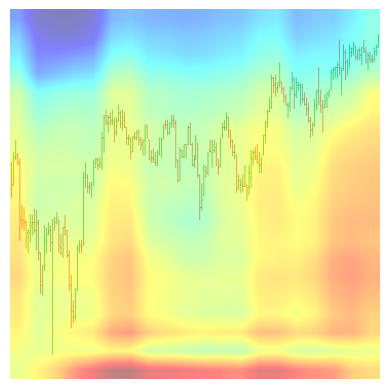

In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- Load 7 YOLOv8 backbones (cut before neck) ---
timeframes = ["1m","3m","5m","15m","1h","4h","1d"]
backbones = []
for tf in timeframes:
    m = YOLO("./best.pt").model
    backbone = nn.Sequential(*list(m.model[:10]))  # keep layers 0–9
    backbones.append(backbone.eval())

# --- Load dummy image ---
img = cv2.imread("./dummy.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (640, 640))
img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().unsqueeze(0) / 255.0

# --- Run through each backbone ---
feats = []
with torch.no_grad():
    for bb in backbones:
        x = img_tensor.clone()
        for layer in bb:
            x = layer(x)
        feats.append(x)

print("Feature shapes:", [f.shape for f in feats])

# --- Align spatial sizes ---
target_h, target_w = feats[0].shape[2], feats[0].shape[3]
aligned = [torch.nn.functional.interpolate(f, size=(target_h, target_w), mode="bilinear") for f in feats]

# --- Concatenate and fuse ---
concat = torch.cat(aligned, dim=1)
fusion = nn.Conv2d(concat.shape[1], 64, 1)  # compress channels to 64
fused = fusion(concat)

print("Fused feature map shape:", fused.shape)

# --- Visualize one feature channel ---
# --- Visualize averaged feature map across all channels ---
feature_map = fused[0].mean(0).detach().cpu().numpy()  # average across channels
feature_map = cv2.resize(feature_map, (img.shape[1], img.shape[0]))
feature_map = (255 * (feature_map - feature_map.min()) / (np.ptp(feature_map) + 1e-6)).astype(np.uint8)

heatmap = cv2.applyColorMap(feature_map, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



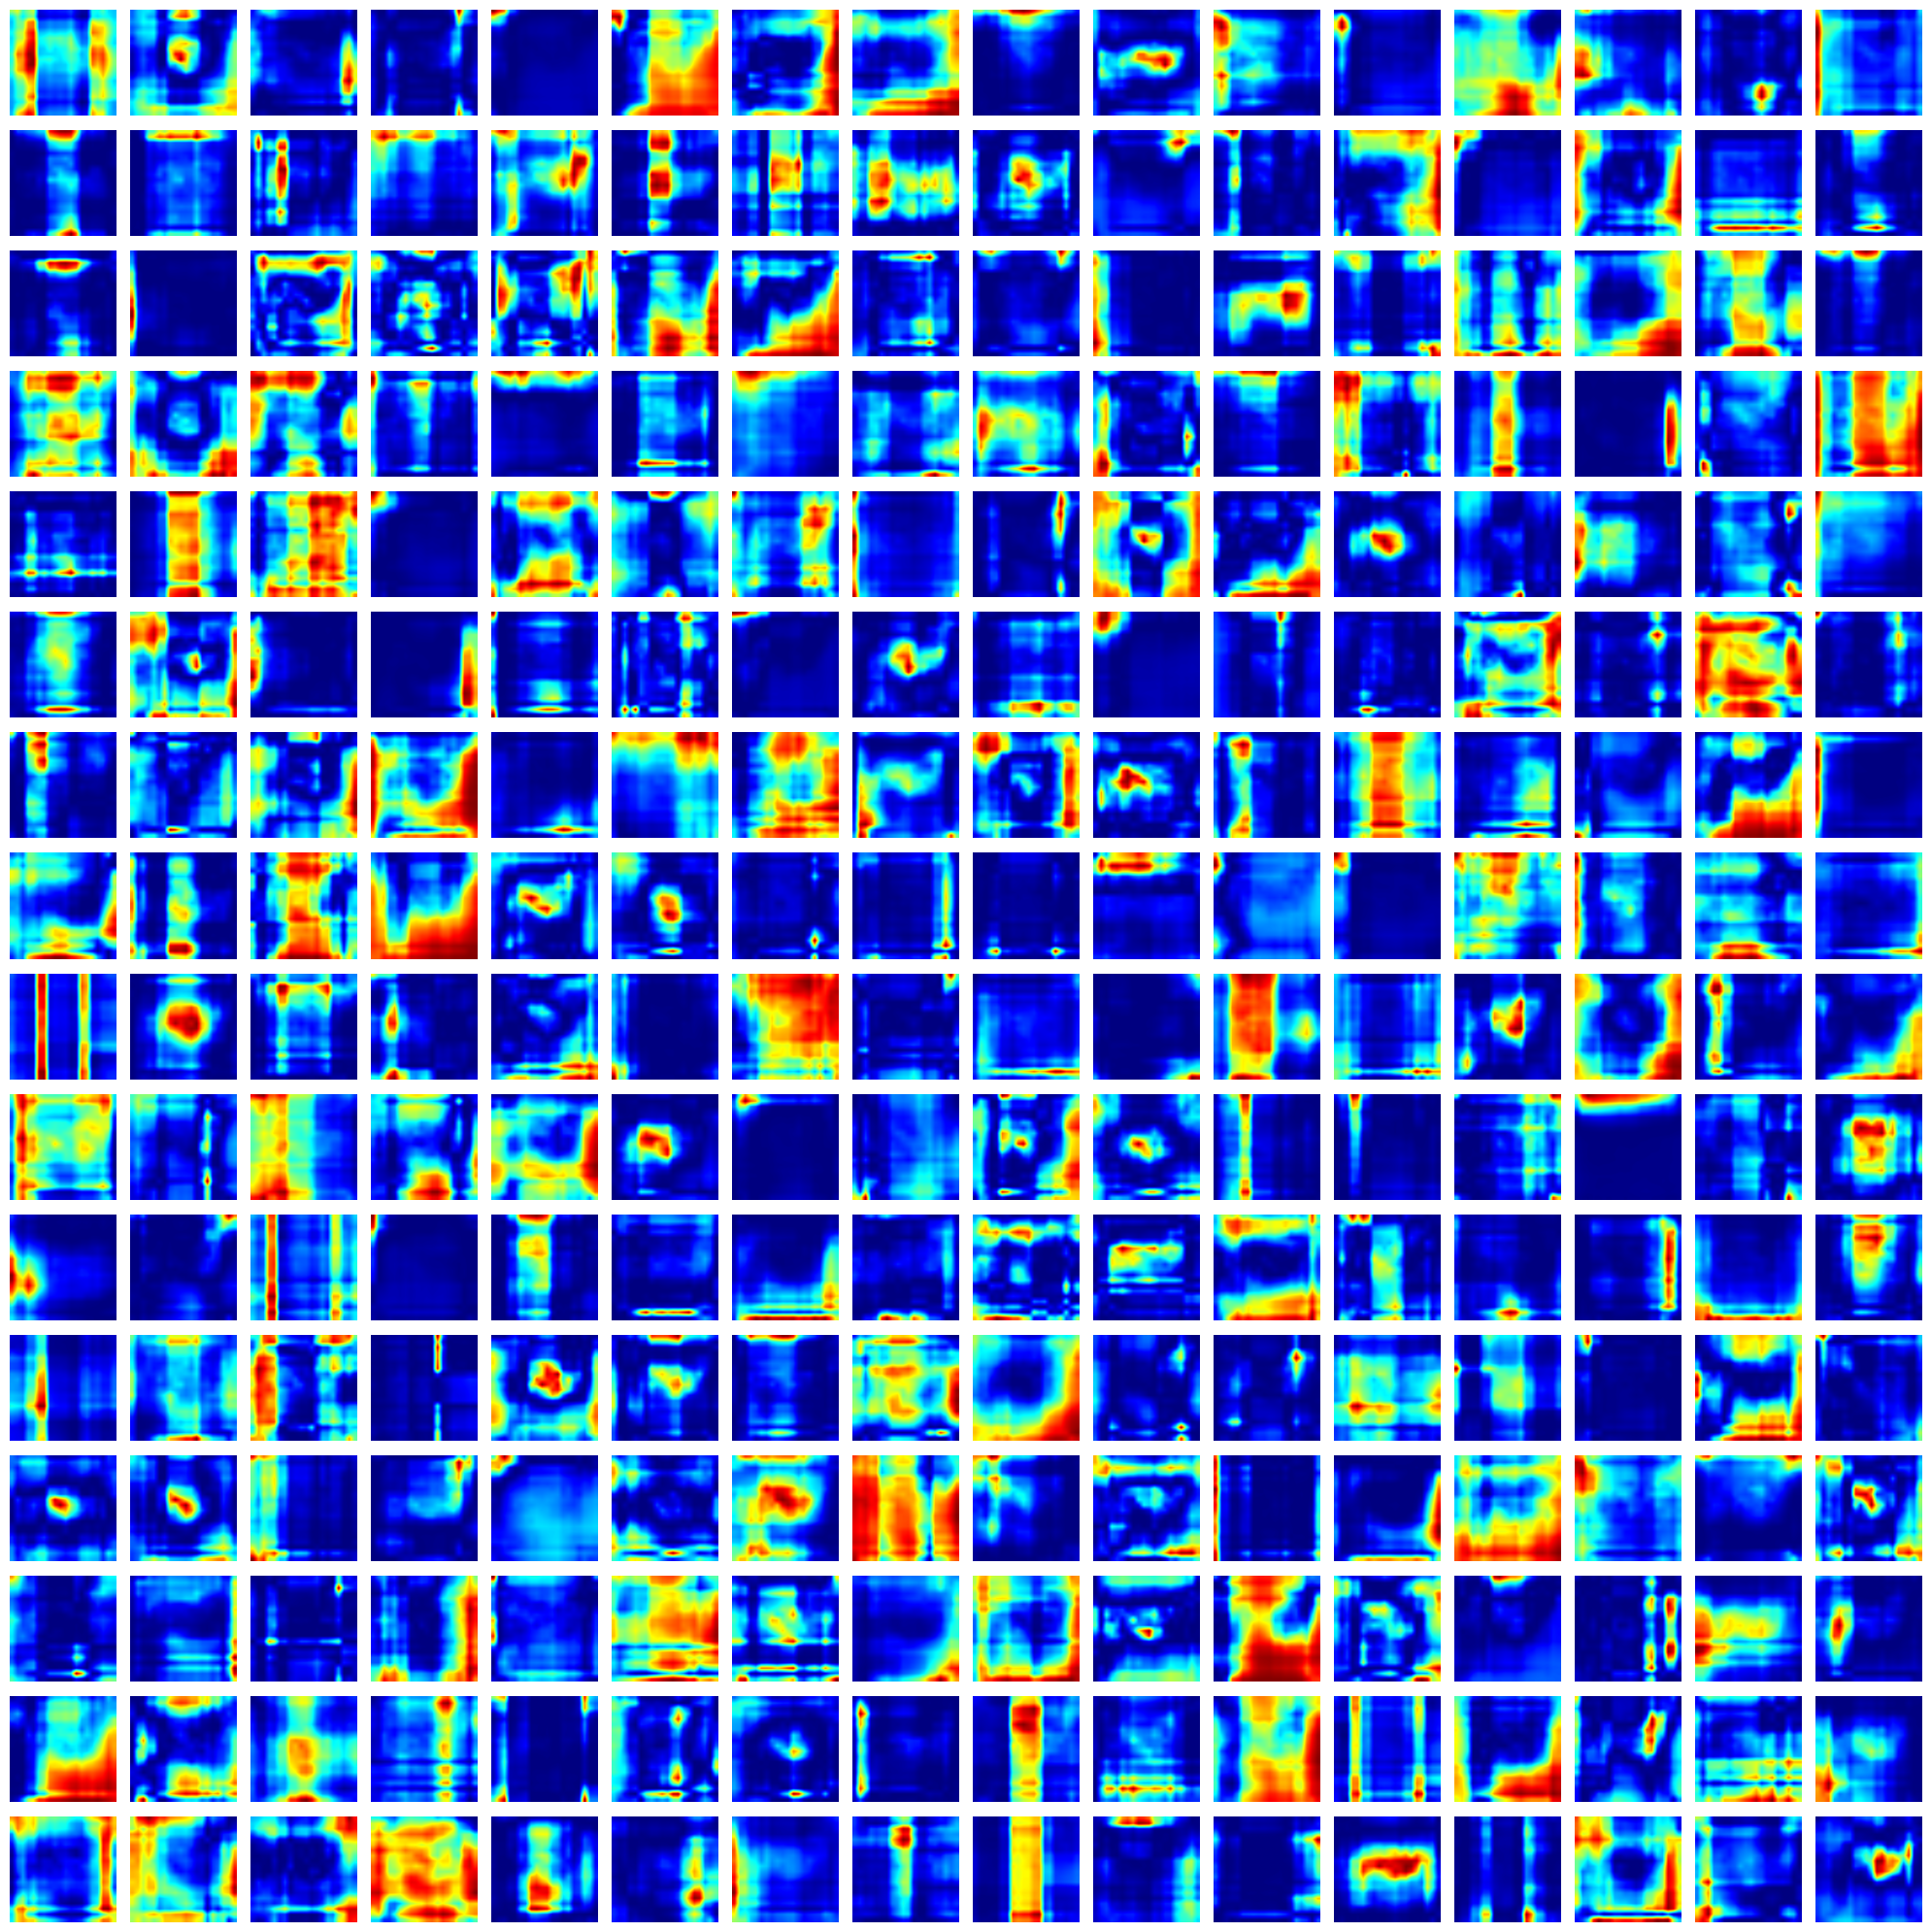

In [2]:
# Pick one model’s feature map (say feats[0])
f = feats[0][0].detach().cpu().numpy()  # shape: [256, H, W]

num_channels = f.shape[0]
grid_cols = 16  # number of maps per row
grid_rows = int(np.ceil(num_channels / grid_cols))

plt.figure(figsize=(20, 20))

for i in range(num_channels):
    fmap = f[i]
    fmap = cv2.resize(fmap, (img.shape[1], img.shape[0]))
    fmap = (255 * (fmap - fmap.min()) / (np.ptp(fmap) + 1e-6)).astype(np.uint8)

    heatmap = cv2.applyColorMap(fmap, cv2.COLORMAP_JET)

    plt.subplot(grid_rows, grid_cols, i+1)
    plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()


In [1]:
# ====================================
# Multi-TF PPO Training Demo
# ====================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import numpy as np
import random

from Backbone import MultiTFEncoder  # ✅ uses 7 encoders

# ====================================
# PPO Agent
# ====================================
class MarketRLAgent(nn.Module):
    def __init__(self, in_channels, hidden_dim=256, num_actions=3):
        super().__init__()
        self.fc = nn.Linear(in_channels * 20 * 20, hidden_dim)
        self.policy_head = nn.Linear(hidden_dim, num_actions)
        self.value_head = nn.Linear(hidden_dim, 1)

    def forward(self, fused_multi_tf):
        x = fused_multi_tf.view(fused_multi_tf.size(0), -1)  # flatten
        x = torch.relu(self.fc(x))
        return self.policy_head(x), self.value_head(x)


# ====================================
# PPO loss (simplified)
# ====================================
def ppo_loss(new_log_probs, old_log_probs, advantages, values, returns,
             clip=0.2, vf_coef=0.5, ent_coef=0.01):
    ratio = torch.exp(new_log_probs - old_log_probs)
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1 - clip, 1 + clip) * advantages
    policy_loss = -torch.min(surr1, surr2).mean()

    value_loss = F.mse_loss(values.view(-1), returns.view(-1))
    entropy = - (torch.exp(new_log_probs) * new_log_probs).mean()

    return policy_loss + vf_coef * value_loss - ent_coef * entropy


# ====================================
# Utils: load image
# ====================================
def load_image(path, size=(640, 640)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, size)
    tensor = torch.from_numpy(img_resized).permute(2,0,1).float().unsqueeze(0) / 255.0
    return img, tensor


# ====================================
# Demo PPO Training Loop (7 TFs)
# ====================================
print("\n[DEMO] Multi-TF PPO training (7 TFs)")

# --- Setup encoders ---
timeframes = ["1m","3m","5m","15m","1h","4h","1d"]
multi_encoder = MultiTFEncoder(timeframes, backbone_path="yolov8n.pt")

# --- Load demo images ---
prev_img, prev_tensor = load_image("./dummy.png")
curr_img, curr_tensor = load_image("./ohlc_180_360.png")

# --- RL agent ---
in_channels = 64 * len(timeframes)  # each encoder outputs 64 channels
agent = MarketRLAgent(in_channels=in_channels, hidden_dim=256, num_actions=3)
optimizer = optim.Adam(agent.parameters(), lr=1e-4)

# --- Fake rollout training ---
num_steps = 5
for step in range(num_steps):
    # forward pass through multi-tf encoder
    data_dict = {tf: (prev_tensor, curr_tensor, prev_img, curr_img) for tf in timeframes}
    fused_multi_tf = multi_encoder(data_dict)  # [B, 64*TFs, H, W]

    # forward pass RL agent
    policy_logits, value = agent(fused_multi_tf)
    dist = torch.distributions.Categorical(logits=policy_logits)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    # fake reward (random for demo)
    reward = torch.tensor([random.choice([-1.0, 0.0, 1.0])])
    returns = reward
    advantages = returns - value.detach().squeeze()

    # compute PPO loss
    loss = ppo_loss(
        new_log_probs=log_prob,
        old_log_probs=log_prob.detach(),
        advantages=advantages,
        values=value,
        returns=returns
    )

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"[STEP {step+1}] Action={action.item()} | Reward={reward.item()} | Loss={loss.item():.4f}")

print("\n[RESULT] Training loop complete ✅")



[DEMO] Multi-TF PPO training (7 TFs)
[INFO] Encoder initialized: yolov8n.pt, pos_dim=16, out_channels=64
[INFO] Encoder initialized: yolov8n.pt, pos_dim=16, out_channels=64
[INFO] Encoder initialized: yolov8n.pt, pos_dim=16, out_channels=64
[INFO] Encoder initialized: yolov8n.pt, pos_dim=16, out_channels=64
[INFO] Encoder initialized: yolov8n.pt, pos_dim=16, out_channels=64
[INFO] Encoder initialized: yolov8n.pt, pos_dim=16, out_channels=64
[INFO] Encoder initialized: yolov8n.pt, pos_dim=16, out_channels=64
[INFO] Fusion conv initialized: in=274, out=64
[INFO] Fusion conv initialized: in=274, out=64
[INFO] Fusion conv initialized: in=274, out=64
[INFO] Fusion conv initialized: in=274, out=64
[INFO] Fusion conv initialized: in=274, out=64
[INFO] Fusion conv initialized: in=274, out=64
[INFO] Fusion conv initialized: in=274, out=64
[STEP 1] Action=2 | Reward=1.0 | Loss=-0.4759
[STEP 2] Action=2 | Reward=1.0 | Loss=30.4983
[STEP 3] Action=2 | Reward=0.0 | Loss=4.7729
[STEP 4] Action=2 | 